# Replication of GCN and GAT results on Cora using the GAT notation

[GCN](https://arxiv.org/abs/1609.02907) and [GAT](https://arxiv.org/abs/1710.10903) are probably the first two Graph Neutal Network (GNN) architectures that a beginner will find out there. Nowadays (end of 2021), there are a couple of libraries like [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) (PyG) and [Deep Graph Library](https://docs.dgl.ai/) (DGL) which provide the basic building blocks of GCN, GAT and many more architectures out-of-the-box. In this notebook I implement the most minimal version of the GCN and GAT architectures using pure `torch` to reproduce the results on the Cora dataset. As a reference implementation we look at the PyG implementation [here](print_model_params_shape_and_return_params). 

To load the data we use `torch_geometric.dataset` as data preprocessing is not the main objective of this notebook. 

Following citation style is used throughout the notebook:
- [gcn] - Kipf and Welling, ["Semi-Supervised Classification with Graph Convolutional Networks"](https://arxiv.org/abs/1609.02907), 2017
- [gat] - Velickovic et. al, ["Graph Attention Network"](https://arxiv.org/abs/1710.10903), 2018

Credit: the degree distribution plot and the t-SNE plot are copied from [Aleska Gordic's GAT impelementation](https://github.com/gordicaleksa/pytorch-GAT). Thank you Aleksa!

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')  # to enfoce cpu
print('device: ', device)

device:  cuda


## Cora

*The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.* - [source](https://relational.fit.cvut.cz/dataset/CORA)

Thus, the dataset can be represented by:
- x:  feature matrix of size (num_publications, num_unique_words) = (2700, 1433)
- edge_index: list of pairs for each citation. `torch_geometric` provides each citation twice as if the cited paper would have cited the newer one, thus making the citation graph undirected. Shape: (2, num_citations*2) = (2, 10858)
- y: class to which each paper belongs in range (0,6). Shape: (num_publications) = (2708)

---
Lets first load the data.

In [3]:
dataset = Planetoid(root='/home/artur/data/Cora', name='Cora')
print('dataset: ', dataset)
data = dataset[0]
print('data: ', data)
data = data.to(device)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

dataset:  Cora()
data:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


The most common data split is the following:
- training: [0:140] with 20 publication from each of the 7 classes
- validation: [140:140+500]
- testing: [1708:2708]

This split is used in both [gcn] and [gat] and it is provided by default in `torch_geometric.datasets`.

We now plot these ranges and the labels of all publications in the dataset.

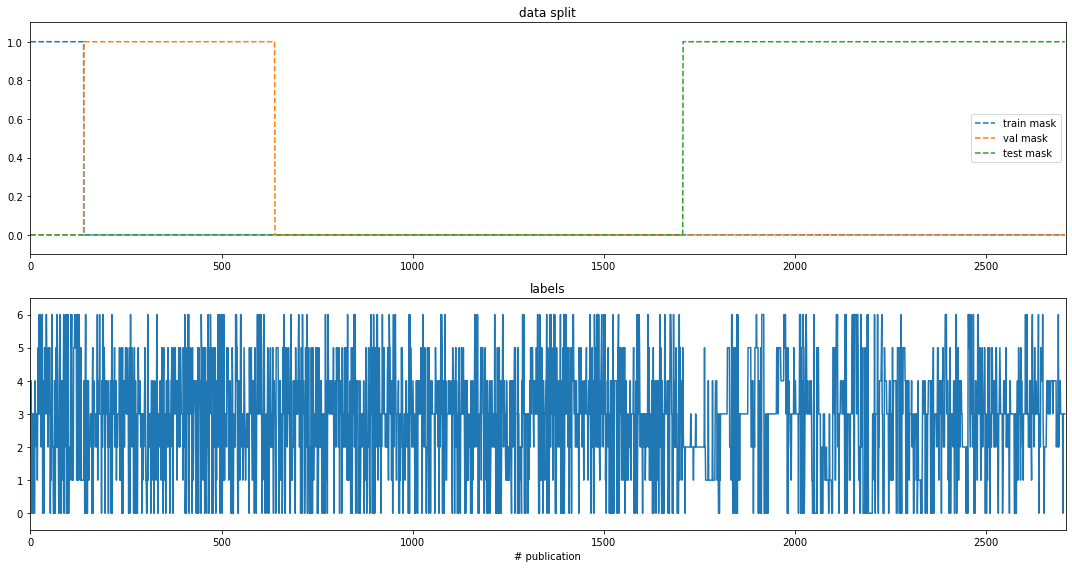

In [4]:
fig, axs = plt.subplots(2,1, figsize=(15,8))

axs[0].set_title('data split')
axs[0].plot(dataset[0].train_mask, '--', label='train mask')
axs[0].plot(dataset[0].val_mask, '--', label='val mask')
axs[0].plot(dataset[0].test_mask, '--', label='test mask')
axs[0].set_xlim([-1, 2709])
axs[0].set_ylim([-.1, 1.1])
axs[0].legend()

axs[1].set_title('labels')
axs[1].plot(dataset[0].y)
axs[1].set_xlim([-1, 2709])
axs[1].set_ylim([-.5, 6.5])
axs[1].set_xlabel('# publication')

plt.tight_layout()
plt.show()

We could also visualize the degrees of the nodes.

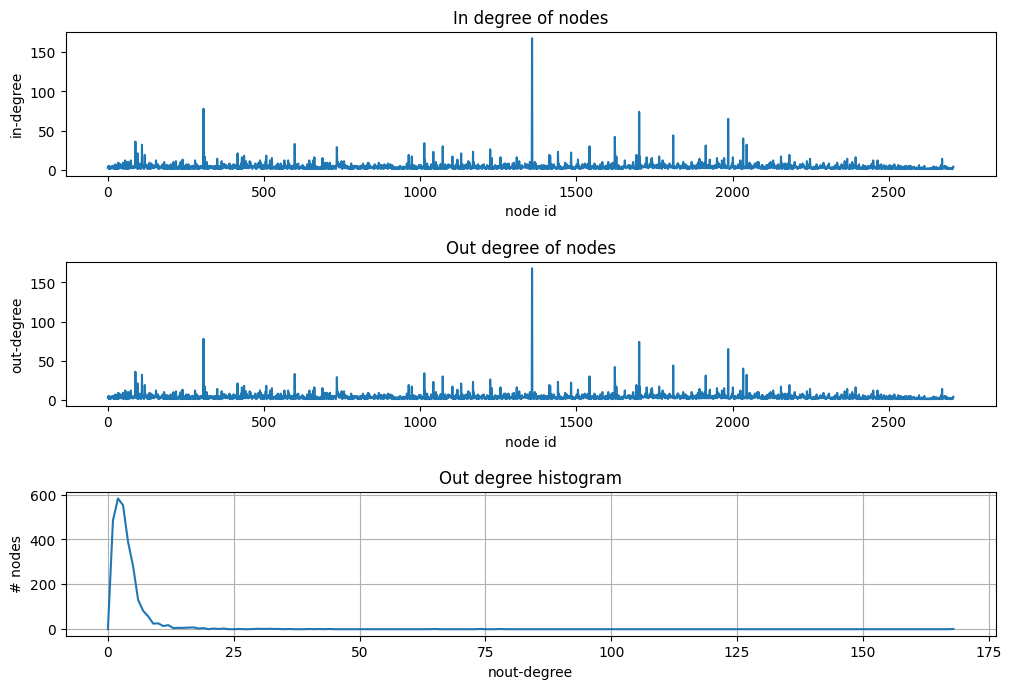

In [5]:
def vis_degrees(ds):
    """from https://github.com/gordicaleksa/pytorch-GAT/blob/main/The%20Annotated%20GAT%20(Cora).ipynb"""
    in_degree = np.zeros(ds[0].num_nodes, dtype=int)
    out_degree = np.zeros(ds[0].num_nodes, dtype=int)

    for edge in ds[0].edge_index.T:
        in_degree[edge[0]] += 1
        out_degree[edge[1]] += 1

    out_hist = np.bincount(out_degree)

    fig = plt.figure(figsize=(12,8), dpi=100)
    fig.subplots_adjust(hspace=0.6)
    
    plt.subplot(311)
    plt.plot(in_degree)
    plt.xlabel('node id'); plt.ylabel('in-degree'); plt.title('In degree of nodes')

    plt.subplot(312)
    plt.plot(out_degree)
    plt.xlabel('node id'); plt.ylabel('out-degree'); plt.title('Out degree of nodes')

    plt.subplot(313)
    plt.plot(out_hist)
    plt.xlabel('nout-degree'); plt.ylabel('# nodes'); plt.title('Out degree histogram')
    plt.grid()

    plt.show()    
    
vis_degrees(dataset)

## utils

In [6]:
def A_hat_from_edge_index(edge_index):
    num_nodes = edge_index.max() + 1
    num_edges = edge_index.shape[1]

    # adjacency matrix w/o self-connections 
    A = torch.sparse_coo_tensor(edge_index.tolist(),
                                torch.ones(num_edges),
                                size=(num_nodes, num_nodes))
    identity_N = torch.sparse_coo_tensor(torch.outer(torch.ones(2), 
                                        torch.arange(0,num_nodes)),
                                        torch.ones(num_nodes))
                                        
    # adjacency matrix w/ self-connections, [gcn, p.2]
    A_tilde = A + identity_N
    # print('A_tilde: ', A_tilde)

    # normalization as done in [gcn, p.3]
    D_tilde = torch.sparse.sum(A_tilde, dim=0)
    D_tilde_pow_m05 = torch.pow(D_tilde, -0.5)
    D_tilde_pow_m05 = torch.sparse_coo_tensor(torch.outer(torch.ones(2), 
                                            torch.arange(num_nodes)), 
                                            D_tilde_pow_m05.values())
    # print('D_tilde_pow_m05: ', D_tilde_pow_m05)
    A_hat = torch.sparse.mm(D_tilde_pow_m05, torch.sparse.mm(A_tilde, D_tilde_pow_m05))
    # print('A_hat: ', A_hat)
    return A_hat

In [7]:
def train(model, optimizer, data):
    """from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py"""
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return model


@torch.no_grad()
def test(model, data):
    """from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py"""    
    model.eval()
    out, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs

def add_log(logs: dict, epoch: int, train_acc, val_acc, test_acc, print_frequency=50):
    if epoch % print_frequency == 0:
        print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
            f'Test: {test_acc:.4f}')

    logs['epoch'].append(epoch)
    logs['train'].append(train_acc)
    logs['val'].append(val_acc)
    logs['test'].append(test_acc)
    return logs

def plt_logs(logs):
    plt.figure()
    plt.title('Accuracy')
    for i in ['train', 'val', 'test']:
        plt.plot(logs['epoch'], logs[i], label=i)
    plt.legend()
    plt.grid()
    plt.ylim([0.6, 1.01])
    plt.tight_layout()
    plt.show()

In [8]:
def tsne_plt(model, data):
    """visualization using tsne plot
    source: https://github.com/gordicaleksa/pytorch-GAT
    and sklearn.manifold.TSNE
    """
    
    model.eval()
    scores = model(data).detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(scores)
    data.y = data.y.cpu()
    
    fig = plt.figure(figsize=(12,8), dpi=80)  # otherwise plots are really small in Jupyter Notebook
    for class_id in range(scores.shape[1]):
        plt.scatter(t_sne_embeddings[data.y == class_id, 0], t_sne_embeddings[data.y == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
    plt.show()
    data.y = data.y.to(device)

In [9]:
def print_model_params_shape_and_return_params(model):
    """for all model parameters, print their shape
    
    Returns
    -------
    (dict, list)
        (parameter tensors identified by name, pameter names)  
    """
    par = {}
    par_names = []
    for name, param in model.named_parameters():
        par[f'{name:s}'] = param.data
        par_names.append(f'{name}')
        print(f'{name}.shape = {param.data.shape}')
    return par, par_names

## 1 GCN

### 1.1 Reference implementation with Pytorch Geometric

Pytorch Geometric implementation of GCN algorithm copied from [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html).

We use that implementation as a reference and try to reproduce the same results with our much simpler network in the next subsection.

Epoch: 000, Train: 0.4071, Val: 0.2600, Test: 0.2460
Epoch: 050, Train: 1.0000, Val: 0.7720, Test: 0.7980
Epoch: 100, Train: 1.0000, Val: 0.7820, Test: 0.8050
Epoch: 150, Train: 1.0000, Val: 0.7740, Test: 0.7980
Epoch: 200, Train: 1.0000, Val: 0.7740, Test: 0.8090


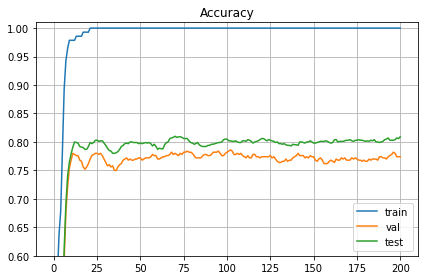

In [10]:
from torch_geometric.nn import GCNConv

class GCN_PyG(torch.nn.Module):
    """from https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html"""
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

gcn_pyg = GCN_PyG(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(gcn_pyg.parameters(), lr=0.01, weight_decay=5e-4)
logs = {'epoch': [], 'train': [], 'val': [], 'test': []}

for epoch in range(201):
    gcn_pyg = train(gcn_pyg, optimizer, data)
    train_acc, val_acc, test_acc = test(gcn_pyg, data)
    logs = add_log(logs, epoch, train_acc, val_acc, test_acc, print_frequency=50)
plt_logs(logs)

### 1.2 My implementation with layer class

Epoch: 000, Train: 0.1429, Val: 0.0580, Test: 0.0640
Epoch: 050, Train: 1.0000, Val: 0.7620, Test: 0.7830
Epoch: 100, Train: 1.0000, Val: 0.7720, Test: 0.8010
Epoch: 150, Train: 1.0000, Val: 0.7720, Test: 0.8030
Epoch: 200, Train: 1.0000, Val: 0.7780, Test: 0.8100


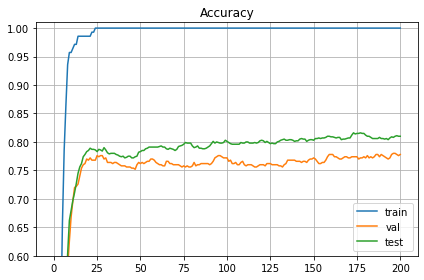

In [11]:
class GCN_Layer(nn.Module):
    def __init__(self, F_IN, F_OUT):
        super().__init__()
        """forward GCN function as in [gcn, Sec. 5.2]

        Parameters
        ----------
        F_IN : int
            number of input features
        F_OUT : int
            number of output features 
        """

        self.lin1 = nn.Linear(F_IN, F_OUT) 
        self.A_hat = None

    def forward(self, x, edge_index):
        """forward GCN function as in [gcn, Sec. 5.2]

        Parameters
        ----------
        x : torch.tensor, shape=(N, F_IN)
            feature matrix
        edge_index : torch.tensor, shape=(2, E)
            pairs of connected nodes excluding self-connections

        Returns
        -------
        torch.tensor, shape(N, C)

        Note
        ----
        Dimensions are denoted as:
            E : number of edges excluding self-connections
            F_IN : number of input features
            F_OUT : number of output features
            N : number of edges  
        """
        
        # construct normalized adjacency matrix A_hat as define in [gcn, p.3]
        # A_hat contains self-connections in contrast to edge_index.
        # Here we fix the adjacency matrix because we work in the transductive setting. 
        # This saves computation time, but it does not generalize to inductive learning
        if self.A_hat is None:
            self.A_hat = A_hat_from_edge_index(edge_index).to(device)
        
        x = self.lin1(x)  # (N, F_IN)*(F_IN, F_OUT) -> (N, F_OUT)
        x = self.A_hat @ x   # (N, N)*(N, F_OUT) -> (N, F_OUT)
        return x 

    
class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        """forward GCN function as in [gcn, Sec. 5.2]

        Parameters
        ----------
        number_features : int
            number of input features
        num_classes : int
            number of node classes

        Note
        ----
        Dimensions are denoted as:
            C : number of output classes
            F : number of input features
            F_hidden : 16 is the number of hidden dimensions        
        """
        self.C = num_classes
        self.F = num_features
        self.F_hidden = 16
        self.conv1 = GCN_Layer(self.F, self.F_hidden)
        self.conv2 = GCN_Layer(self.F_hidden, self.C)

    def forward(self, data):
        """forward GCN function as in [gcn, Sec. 5.2]

        Parameters
        ----------
        data : torch_geometric.dataset

        Returns
        -------
        torch.tensor, shape(N,C)

        Note
        ----
        Dimensions are denoted as:
            C : number of output classes
            E : number of edges without self-connections
            F : number of input features
            F_hidden : 16 is the number of hidden dimensions        
            N : number of nodes
        """
        x, edge_index = data.x, data.edge_index  # (N, F), (2, E)

        x = self.conv1(x, edge_index)  # (N, F_hidden)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)  # (N, C)
        return F.log_softmax(x, dim=1)

model = GCN(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
logs = {'epoch': [], 'train': [], 'val': [], 'test': []}

for epoch in range(201):
    model = train(model, optimizer, data)
    train_acc, val_acc, test_acc = test(model, data)
    logs = add_log(logs, epoch, train_acc, val_acc, test_acc, print_frequency=50)
plt_logs(logs)

### 1.3 My implementation without layer class

As a single class, i.e. without introducing a layer class, the GCN class can be defines as shown below. 

This structure most intuitively follows the notation used in the GCN paper [gcn].

Epoch: 000, Train: 0.1929, Val: 0.1520, Test: 0.1230
Epoch: 050, Train: 1.0000, Val: 0.7520, Test: 0.7900
Epoch: 100, Train: 1.0000, Val: 0.7620, Test: 0.8000
Epoch: 150, Train: 1.0000, Val: 0.7740, Test: 0.8000
Epoch: 200, Train: 1.0000, Val: 0.7660, Test: 0.7970


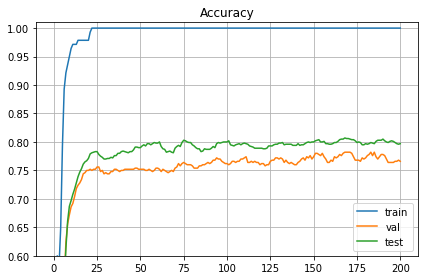

In [12]:
class GCN_(nn.Module):
    def __init__(self, num_features, num_classes, A_hat):
        super().__init__()
        """forward GCN function as in [gcn, Sec. 5.2]

        Parameters
        ----------
        num_features : int
            number of input features
        num_classes : int
            number of classes 
        A_hat : torch.sparse_coo_tensor, shape(N,F)
            adjacency matrix defined in [gcn, p.3]
        """
        self.F = num_features 
        self.C = num_classes  
        self.A_hat = A_hat
        self.N = A_hat.shape[0]  # number of nodes

        self.F_hidden = 16  # number of hidden features
        self.lin1 = nn.Linear(self.F, self.F_hidden) 
        self.lin2 = nn.Linear(self.F_hidden, self.C)

    def forward(self, data):
        """forward GCN function as in [gcn, Sec. 5.2]

        Parameters
        ----------
        x : torch.tensor, shape(N,F)

        Returns
        -------
        torch.tensor, shape(N,C)
        """
        x = data.x
        
        x = self.lin1(x)  # (N, F)*(F, F_hidden) -> (N, F_hidden)
        x = self.A_hat @ x   # (N, N)*(N, F_hidden) -> (N, F_hidden)
        x = F.dropout(x, training=self.training, p=0.5)
        x = F.relu(x)
        x = self.lin2(x)  # (N, F_hidden)*(F_hidden, C) -> (N, C)
        x = self.A_hat @ x  # (N, N)*(N, C) -> (N, C)

        return F.log_softmax(x, dim=1)  #(N,num_classes] -> (N)

A_hat = A_hat_from_edge_index(data.edge_index)
model = GCN_(dataset.num_features, dataset.num_classes, A_hat.to(device)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
logs = {'epoch': [], 'train': [], 'val': [], 'test': []}

for epoch in range(201):
    model = train(model, optimizer, data)
    train_acc, val_acc, test_acc = test(model, data)
    logs = add_log(logs, epoch, train_acc, val_acc, test_acc, print_frequency=50)
plt_logs(logs)

### 1.4 Visualizations

Here we take the trained PyG model and analyze its output.

First, we look at the 2D embedding of the last layer weights in a t-SNE plot.

/home/artur/code/from_gcn_to_gat/venv1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/artur/code/from_gcn_to_gat/venv1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


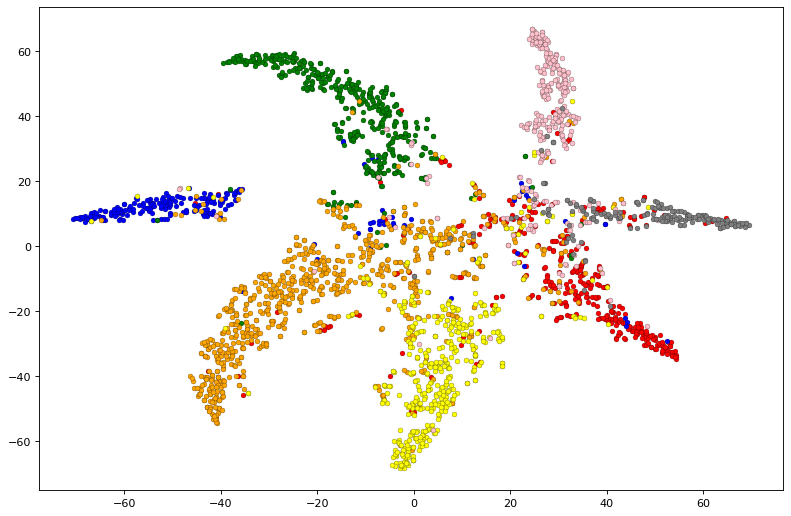

In [13]:
tsne_plt(gcn_pyg, data)

Now, we print the names and shapes of the learnable model parameters.

In [14]:
par, par_names = print_model_params_shape_and_return_params(gcn_pyg)

conv1.bias.shape = torch.Size([16])
conv1.lin.weight.shape = torch.Size([16, 1433])
conv2.bias.shape = torch.Size([7])
conv2.lin.weight.shape = torch.Size([7, 16])


To get a feeling for what the last layer does, we can look at its weights. 

In this plot we see how each of the previously computed representations (aka embeddings) of the nodes are weighted by the last weighting matrix. Basically, the first layer extracts meaningful representations and the last layer select the ones that are most relevant for a given class. For example, the last raw shows that embedding 6-8 of the previous layer correlate well with class 0 and embeddings 4, 9, and 13 correlate negatively.

shape of last layer weights:  (7, 16)


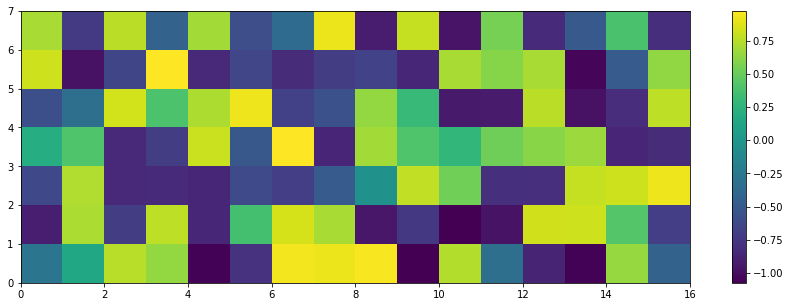

In [131]:
fig = plt.figure(figsize=(15,5))
p = par[par_names[-1]].cpu().numpy() # (7, 16) - second (last) layer weights
print('shape of last layer weights: ', p.shape)
plt.pcolormesh(p)  
plt.colorbar()
plt.show()

## 2 GAT

### 2.1 Reference implementation with Pytorch Geometric

This Pytorch Geometric implementation of GAT algorithm originates from [here](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py).

We use that implementation as a reference and try to reproduce the same results with our much simpler network in the next subsection.

Epoch: 050, Train: 0.9929, Val: 0.7700, Test: 0.7900
Epoch: 100, Train: 1.0000, Val: 0.7760, Test: 0.7920
Epoch: 150, Train: 1.0000, Val: 0.7760, Test: 0.8050
Epoch: 200, Train: 1.0000, Val: 0.7780, Test: 0.8000
Epoch: 250, Train: 1.0000, Val: 0.7860, Test: 0.8130
Epoch: 300, Train: 1.0000, Val: 0.7700, Test: 0.8030
Epoch: 350, Train: 1.0000, Val: 0.7680, Test: 0.7970
Epoch: 400, Train: 1.0000, Val: 0.7640, Test: 0.7990
Epoch: 450, Train: 1.0000, Val: 0.7540, Test: 0.7910
Epoch: 500, Train: 1.0000, Val: 0.7600, Test: 0.7930


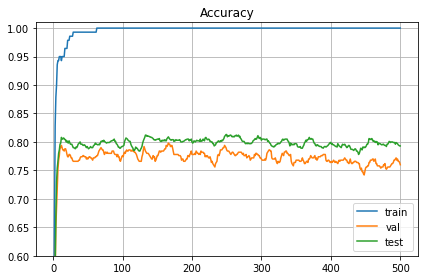

In [15]:
from torch_geometric.nn import GATConv

class GAT_PyG(torch.nn.Module):
    """ from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py"""
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

gat_pyg = GAT_PyG(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(gat_pyg.parameters(), lr=0.005, weight_decay=5e-4)
logs = {'epoch': [], 'train': [], 'val': [], 'test': []}

for epoch in range(1, 501):
    gat_pyg = train(gat_pyg, optimizer, data)
    train_acc, val_acc, test_acc = test(gat_pyg, data)
    logs = add_log(logs, epoch, train_acc, val_acc, test_acc, print_frequency=50)
plt_logs(logs)

### 2.2 My implementation

Epoch: 050, Train: 0.9357, Val: 0.7900, Test: 0.8270
Epoch: 100, Train: 0.9786, Val: 0.7900, Test: 0.8200
Epoch: 150, Train: 0.9929, Val: 0.7920, Test: 0.8080
Epoch: 200, Train: 0.9929, Val: 0.7900, Test: 0.8160
Epoch: 250, Train: 1.0000, Val: 0.7940, Test: 0.8090
Epoch: 300, Train: 1.0000, Val: 0.7940, Test: 0.8150
Epoch: 350, Train: 1.0000, Val: 0.7820, Test: 0.8150
Epoch: 400, Train: 1.0000, Val: 0.7940, Test: 0.8150
Epoch: 450, Train: 1.0000, Val: 0.7900, Test: 0.8040
Epoch: 500, Train: 1.0000, Val: 0.7960, Test: 0.8140


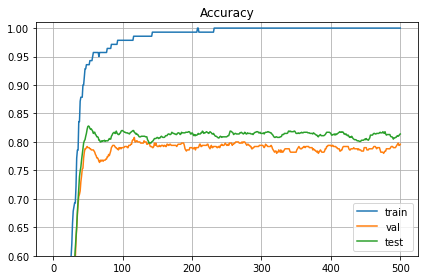

In [16]:
class GAT_Layer(nn.Module):   
    def __init__(self, F_IN: int, F_OUT: int, heads: int, concat: bool = True, 
                 negative_slope: float = 0.2, dropout_rate: float = 0.6):
        super().__init__()
        # TODO:     add_self_loops: bool = True  ???
        """ one GAT layer as in [gat, Sec. 3.3]

        Parameters
        ----------
        F_IN: int
            number of input features; equivalent to "F" in [gat, p.3]
            this is the result of `F_OUT*heads` from the previous layer
        F_OUT: int
            number of output features; equivalent to "F'" in [gat, p.3]
        heads: int
            number of attention heads
        concat: bool
            whether to concatenate the attention heads (True) or to average over them (False)
        negative_slope: float
            angle of negative slope in the LeakyReLU activation
        dropout_rate: float
            dropout rate
        """

        self.F_IN = F_IN
        self.F_OUT = F_OUT  
        self.K = heads
        self.concat = concat
        self.leaky_relu = nn.LeakyReLU(negative_slope)
        self.dropout = nn.Dropout(dropout_rate)

        self.lin = nn.Linear(self.F_IN, self.K * self.F_OUT)
        self.a_src = nn.Parameter(torch.Tensor(1, self.K, self.F_OUT))
        self.a_trg = nn.Parameter(torch.Tensor(1, self.K, self.F_OUT))

        nn.init.xavier_uniform_(self.lin.weight)
        nn.init.uniform_(self.lin.bias)
        nn.init.xavier_uniform_(self.a_src)
        nn.init.xavier_uniform_(self.a_trg)

    def forward(self, x, edge_index):
        """forward GAT function as in [gat, Sec. 3.3]

        Parameters
        ----------
        x : torch.tensor, shape(N, F_IN)
            feature matrix
        edge_index : torch.tensor, shape=(2, E)
            pairs of connected nodes excluding self-connections

        Returns
        -------
        torch.tensor, shape(N, F_OUT)
 
        Notes
        -----
        Scaling of the algorithm wrt number of nodes (N) and edges (E):
        1. compute W*h                  O(|N|)
        2. compute all attentions       O(|E|)
        3. normalize attentions         O(|N|*average_degree)
        4. aggregate weighted messages  O(|N|*average_degree)
        """

        N = x.shape[0]  # number of nodes
        # the input data excludes self-connections but [gat] uses them. So we need to add them
        edge_index_ = self.add_self_connections_to_edge_index(edge_index, N)

        x = self.dropout(x)
        h_prime = self.lin(x).view(N, self.K, self.F_OUT)  # (N, F_IN)*(F_IN, K*F_OUT) -> (N, K*F_OUT) -> (N, K, F_OUT)

        # edge_index_[0] = source; edge_index_[1] = target
        h_src = (h_prime * self.a_src).sum(dim=2)  # ((N, K, F_OUT) * (1, K, F_OUT)).sum(2) -> (N, K)
        h_trg = (h_prime * self.a_trg).sum(dim=2)
        h_prime_edge_src = h_src[edge_index_[0]]  # (E, K)
        h_prime_edge_trg = h_trg[edge_index_[1]] 
        # compute raw attention coefficients `e_{ij}` in paper [gat, p.3]
        e = h_prime_edge_src + h_prime_edge_trg  # (E, K)
        e = self.leaky_relu(e)

        # apply softmax normalization over all source nodes per target node
        e = e - e.max()   # trick to improve numerical stability before computing exponents (for softmax)
        exp_e = e.exp()  # = unnormalized attention for each pair self.edge_pair[0]->self.edge_pair[1]
        trg_normalization = torch.zeros(size=(N, self.K), dtype=x.dtype, device=x.device)  # tensor with normalizing constants for each target node
        index = self.explicit_broadcast(edge_index_[1], exp_e)
        trg_normalization.scatter_add_(0, index, exp_e)   # index1:[E, K], exp_e:[E, K] -> [N, K]
        # In the above line we aggregate the coefficients `e_{ij}` to each target nodes j (in [gat] notation should be i, 
        # but here the second dimension is the target). A small demonstaration of what we do here would be: 
        # for K=2 heads and a graph of 3 nodes with connections 0-1-2:
        # edge_index = torch.tensor([[0,0,1,1,1,2,2],[0,1,0,1,2,1,1]])  # (2,7) = (2, E)
        # trg_index = edge_index[1].repeat(2,1).T                         # (7, 2) = (E, K)
        # out = torch.tensor([[0,1,2,3,4,5,6], [7,7,7,7,7,7,7]]).T    # (7, 2) = (E, K)
        # print(torch.zeros(3, 2, dtype=out.dtype).scatter_add_(0, trg_index, src)) # (3, 2) = (N, K)
        # >> tensor([[ 2, 14], [15, 28], [ 4,  7]])

        # normalized attention coefficients `alpha_{ij}` in paper [gat, p.3]
        alpha = exp_e / (trg_normalization[edge_index_[1]] + 1e-10)  # (E, K), s.t. for a given target, the sum of the sources = 1.
        # validate correctness for each target #node and #head by uncommenting the following line and plugging #node and #head
        # assert alpha[edge_index_[1]==#node, #head]) == 1.

        alpha = self.dropout(alpha)
        src = h_prime[edge_index_[0]]  # (E, K, F_OUT)
        src *= alpha.unsqueeze(-1) 
        out = torch.zeros(size=(N, self.K, self.F_OUT), dtype=x.dtype, device=x.device)
        index = self.explicit_broadcast(edge_index_[1], src)
        out = out.scatter_add(0, index, src)  # (N, K, F_OUT)  # h double prime

        if self.concat:
            out = out.view(N, -1)  # (N, K, F_OUT) -> (N, K*F_OUT)
        else:
            out = out.mean(dim=1)  # (N, K, F_OUT) -> (N, F_OUT)

        return out

    def add_self_connections_to_edge_index(self, edge_index, N):
        self_loop = torch.arange(N, dtype=int).repeat(2,1).to(device)
        edge_index_ = torch.cat((edge_index, self_loop), dim=1)
        return edge_index_

    def explicit_broadcast(self, this, other):
        """from https://github.com/gordicaleksa/pytorch-GAT/blob/main/The%20Annotated%20GAT%20(Cora).ipynb"""
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)
        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.conv1 = GAT_Layer(num_features, 8, heads=8, dropout_rate=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GAT_Layer(8 * 8, num_classes, heads=1, concat=False, dropout_rate=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

gat = GAT(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
logs = {'epoch': [], 'train': [], 'val': [], 'test': []}

for epoch in range(1, 501):
    gat = train(gat, optimizer, data)
    train_acc, val_acc, test_acc = test(gat, data)
    logs = add_log(logs, epoch, train_acc, val_acc, test_acc, print_frequency=50)
plt_logs(logs)

### 2.3 Visualization

/home/artur/code/from_gcn_to_gat/venv1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/artur/code/from_gcn_to_gat/venv1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


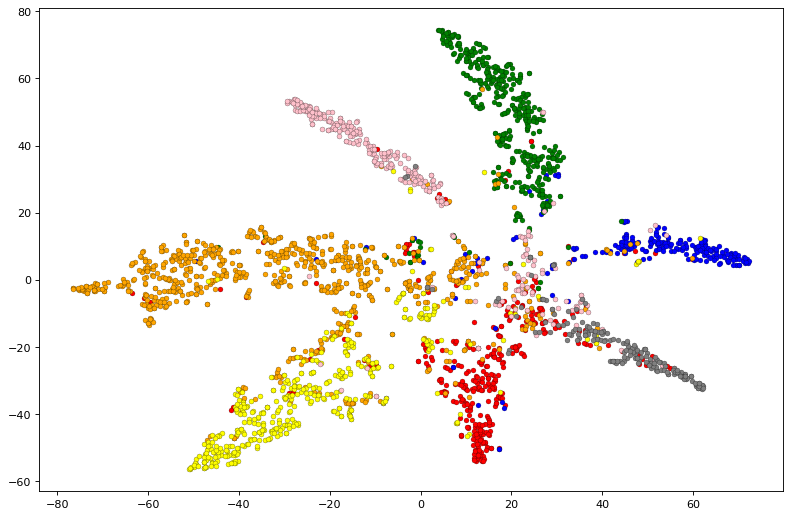

In [17]:
tsne_plt(gat, data)